# Construct Glycolysis+ Pathways and Diagrams
__Notes__
- We assume that most of the sugars already exist in the KnowledgeBase as a result of the notebook `Sugar Forms and Variations`, as well as the core nucleotides and deoxynucleotides, via `Nucleotides in the KB`.
- This notebook builds up the reactions of glycolysis, pentose-phophate, entner-doudoroff, and overflow metabolism, as well as the remaining metabolites not covered by the systematic approaches above.
- We use ChEBI as the origin for most metabolite definitions
  - No access or licensing restrictions
  - The precision and granularity we need, e.g. in terms of protonation states, isomeric forms, etc
- Likewise, RHEA is the origin for reaction definitions.
- However, those sources themselves do not serve our overall goals. So we construct and refine canonical KB versions of all the relevant items. The path is
> EC number -> RHEA reaction -> ChEBI compound -> KB compound -> KB reaction
- Start with EC numbers pulled from reference sources.
  - The starting lists are fairly inclusive, so we may be selective about what we include in any final pathways.

In [1]:
import collections
import copy
from importlib.resources import files
from ipydatagrid import DataGrid
import ipywidgets as widgets
import json
import pandas as pd
from IPython.display import SVG, display

from mosmo.knowledge import kb
from mosmo.model import DS, DbXref, KbEntry, Molecule, Reaction, Pathway, Specialization, Variation
from mosmo.preso.escher import escher_map, escher_model

import edit_tasks

# Data files are resources in the `data` package
import data
def datafile(filename):
    return files(data).joinpath(filename)

KB = kb.configure_kb()

## Glycolysis

### Collect RHEA reactions cross-referenced to these EC numbers

In [2]:
glycolysis_rhea, glycolysis_chebi = edit_tasks.collect_reference_objects(datafile('glycolysis.txt'), KB, KB.RHEA)
print(f'Collected {len(glycolysis_rhea)} reactions on {len(glycolysis_chebi)} molecules')

Collected 28 reactions on 45 molecules


### Manually curate KB compounds
- Assign or edit kbid, name, akas, shorthand, and xrefs
- Generally, any new entry inherits anything it can from the ChEBI entry
- Manually mark KB entries to be updated

In [3]:
tasks = edit_tasks.build_mol_edit_tasks(glycolysis_chebi, KB, KB.compounds)
print(f'{len(tasks)} molecules to edit, {len([task for task in tasks if task.kb_mol.id])} mapped to existing KB molecules')
mol_edit_grid = edit_tasks.MolEditGrid(tasks)
display(mol_edit_grid.grid)

44 molecules to edit, 40 mapped to existing KB molecules


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [4]:
for task in mol_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_mol)
        KB.put(KB.compounds, task.kb_mol)
        task.dirty = False

glycolysis_kb_mols = [task.kb_mol for task in mol_edit_grid.tasks if task.kb_mol.id]

# Manually add Glc[e], used by PTS (to be added later)
glycolysis_kb_mols.append(KB('Glc.D.ext'))

### Build KB versions of all reactions

In [5]:
tasks, skipped = edit_tasks.build_rxn_edit_tasks(glycolysis_rhea, KB, KB.reactions, KB.compounds)
print(f'{len(tasks)} reactions to edit, {len([task for task in tasks if task.kb_rxn.id])} mapped to existing KB reactions')
for rhea_rxn in skipped:
    print(f'Skipped: [{rhea_rxn.id}] {rhea_rxn.name}')

rxn_edit_grid = edit_tasks.RxnEditGrid(tasks)
display(rxn_edit_grid.grid)

26 reactions to edit, 21 mapped to existing KB reactions
Skipped: [10740] alcohol dehydrogenase
Skipped: [10736] * alcohol dehydrogenase


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [6]:
for task in rxn_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_rxn)
        KB.put(KB.reactions, task.kb_rxn)
        task.dirty = False

glycolysis_kb_rxns = [task.kb_rxn for task in rxn_edit_grid.tasks if task.kb_rxn.id]

# Manually add PTS, which does not have a single EC number
glycolysis_kb_rxns.append(KB('pts.glc'))

## Pentose Phosphate and Entner-Doudoroff
- Same approach as for Glycolysis above

In [7]:
ppp_rhea, ppp_chebi = edit_tasks.collect_reference_objects(datafile('ppp.txt'), KB, KB.RHEA)
print(f'Collected {len(ppp_rhea)} reactions on {len(ppp_chebi)} molecules')

tasks = edit_tasks.build_mol_edit_tasks(ppp_chebi, KB, KB.compounds)
print(f'{len(tasks)} molecules to edit, {len([task for task in tasks if task.kb_mol.id])} mapped to existing KB molecules')
mol_edit_grid = edit_tasks.MolEditGrid(tasks)
display(mol_edit_grid.grid)

Collected 10 reactions on 17 molecules
17 molecules to edit, 17 mapped to existing KB molecules


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [8]:
for task in mol_edit_grid.tasks:
    if task.dirty:
        print(task.kb_mol)
        KB.put(KB.compounds, task.kb_mol)
        task.dirty = False

ppp_kb_mols = [task.kb_mol for task in mol_edit_grid.tasks if task.kb_mol and task.kb_mol.id]

In [9]:
tasks, skipped = edit_tasks.build_rxn_edit_tasks(ppp_rhea, KB, KB.reactions, KB.compounds)
print(f'{len(tasks)} reactions to edit, {len([task for task in tasks if task.kb_rxn.id])} mapped to existing KB reactions')
for rhea_rxn in skipped:
    print(f'Skipped: [{rhea_rxn.id}] {rhea_rxn.name}')

rxn_edit_grid = edit_tasks.RxnEditGrid(tasks)
display(rxn_edit_grid.grid)

10 reactions to edit, 10 mapped to existing KB reactions


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [10]:
for task in rxn_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_rxn)
        KB.put(KB.reactions, task.kb_rxn)
        task.dirty = False

ppp_kb_rxns = [task.kb_rxn for task in rxn_edit_grid.tasks if task.kb_rxn.id]

### This writes the `model` file taken as input by escher.github.io
- uncomment to run, of course

In [11]:
# model = escher_model.escher_model('glycolysis_ppp_ov', glycolysis_kb_rxns + ppp_kb_rxns)
# with open('glycolysis_ppp_ov.model.json', 'wt') as f:
#     f.write(json.dumps(model))

## Tie pathway definitions to Escher diagrams
- Diagrams drawn using [Escher](https://escher.github.io)
- That tool continues to work but is unfortunately not still maintained
- To embed in notebooks we use mosmo.preso.escher.escher_map.EscherMap

In [12]:
def build_pathway(pwid, name=None):
    map_json = json.loads(datafile(f'{pwid}.json').read_text())
    diag = escher_map.EscherMap(map_json)

    pw_reactions = []
    for rnode in diag.reactions:
        kb_rxn = KB.get(KB.reactions, rnode.reaction_id)
        if kb_rxn:
            pw_reactions.append(kb_rxn)
        else:
            print(f'{rnode.reaction_id} not found')

    return Pathway(
        id = pwid,
        name = name or pwid,
        reactions = pw_reactions,
        diagram = map_json,
    )

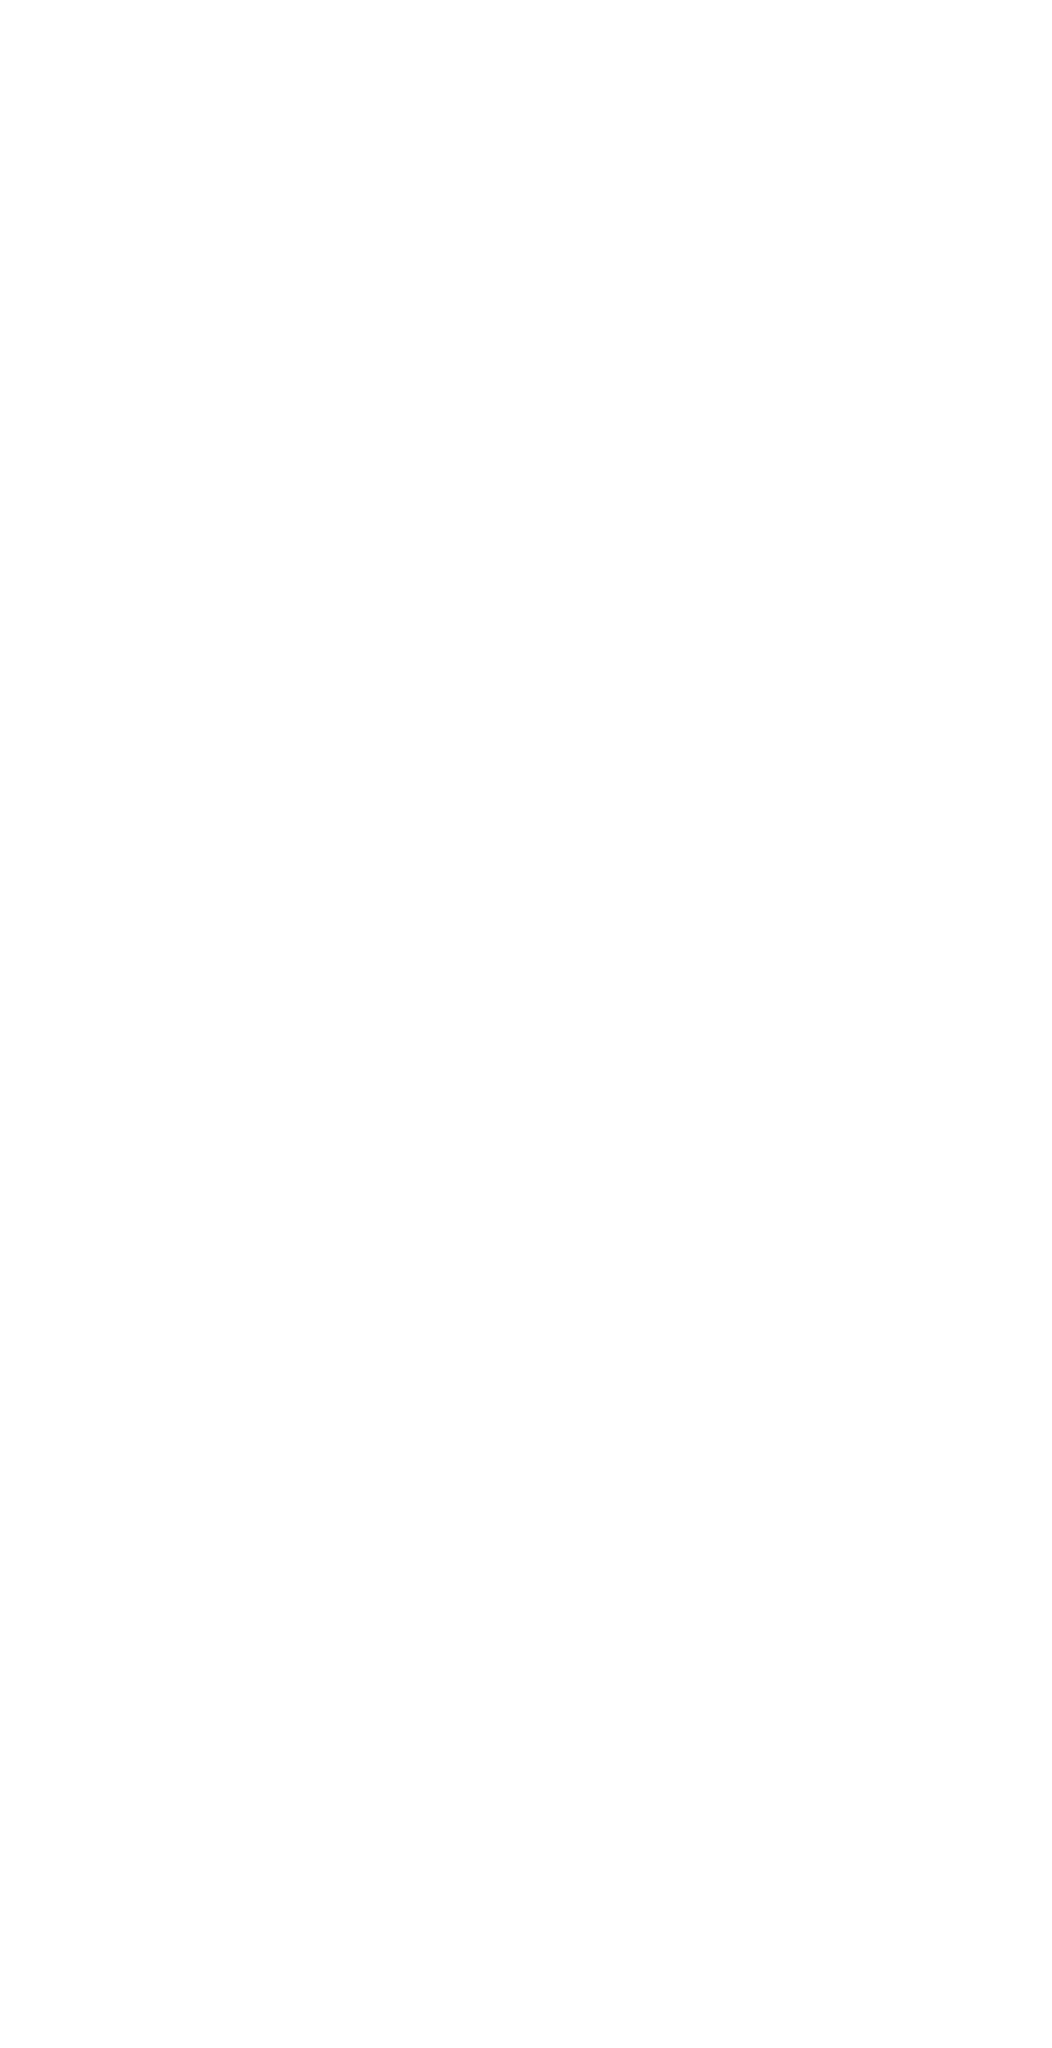

In [13]:
glycolysis = build_pathway('glycolysis', 'Glycolysis')
SVG(escher_map.EscherMap(glycolysis.diagram, width="10cm").draw())

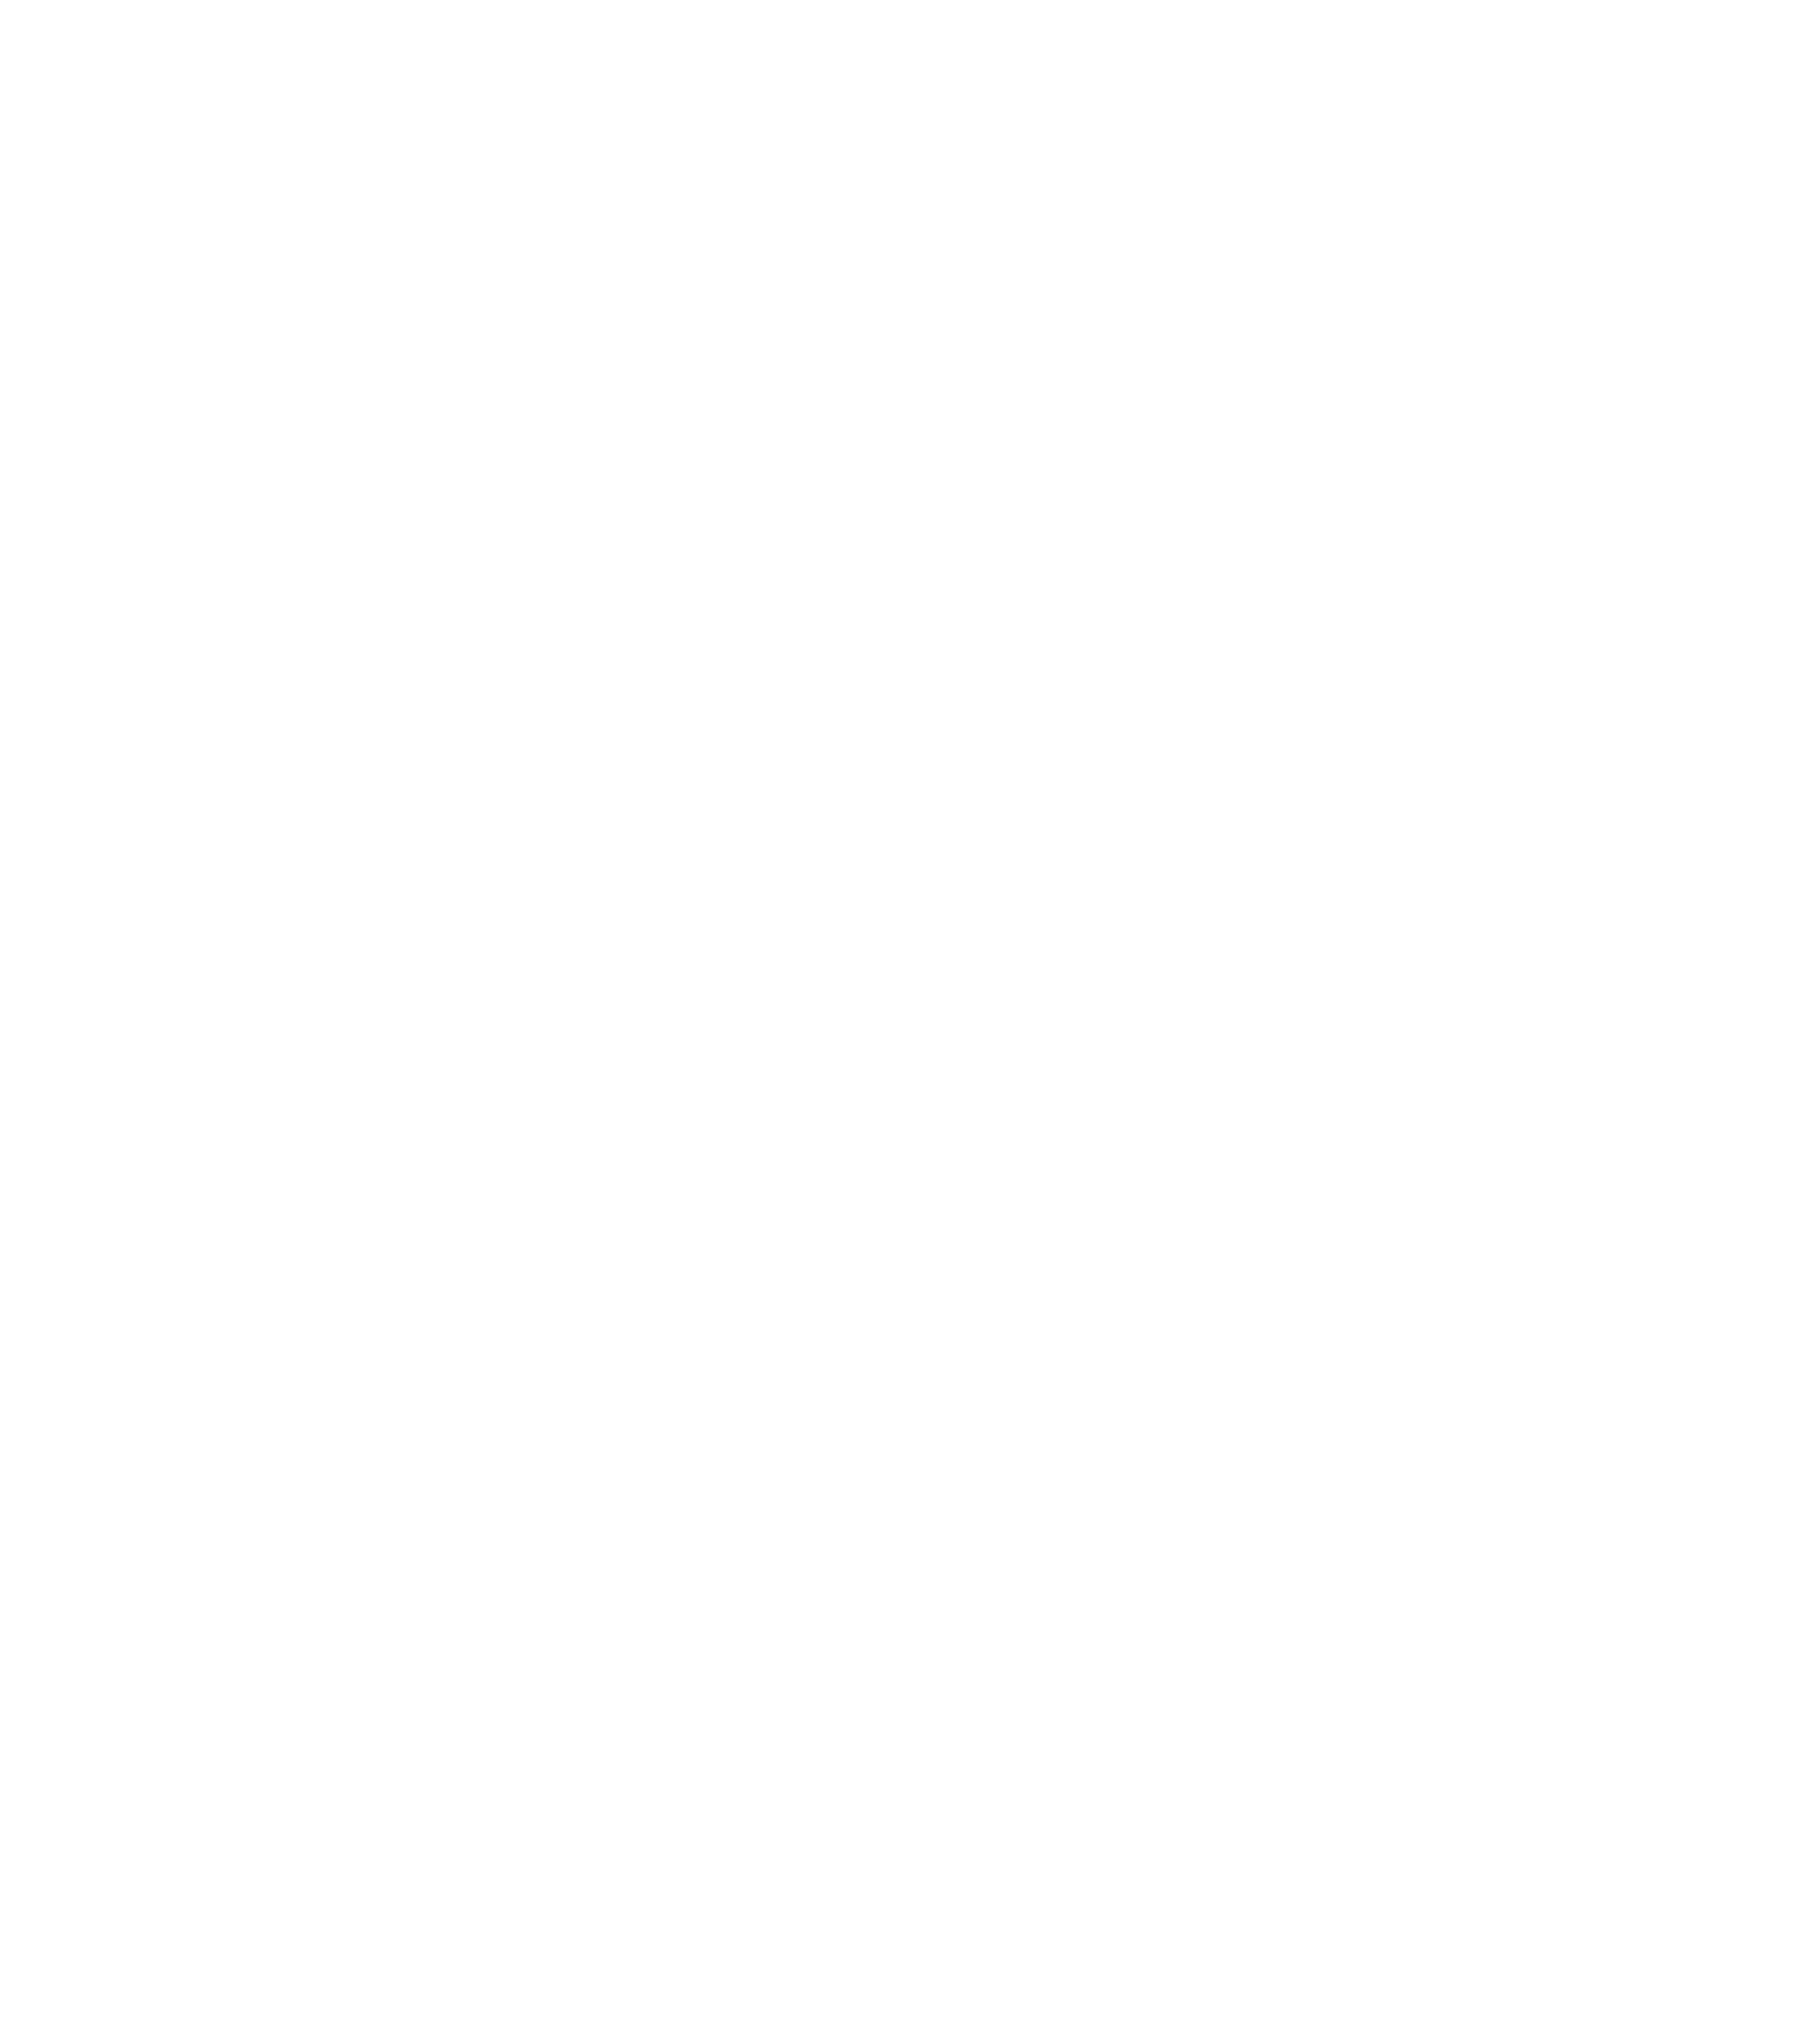

In [14]:
glycolysis_ppp_ov = build_pathway('glycolysis_ppp_ov', 'Glycolysis + PPP + Overflow')
SVG(escher_map.EscherMap(glycolysis_ppp_ov.diagram, width="12cm").draw())

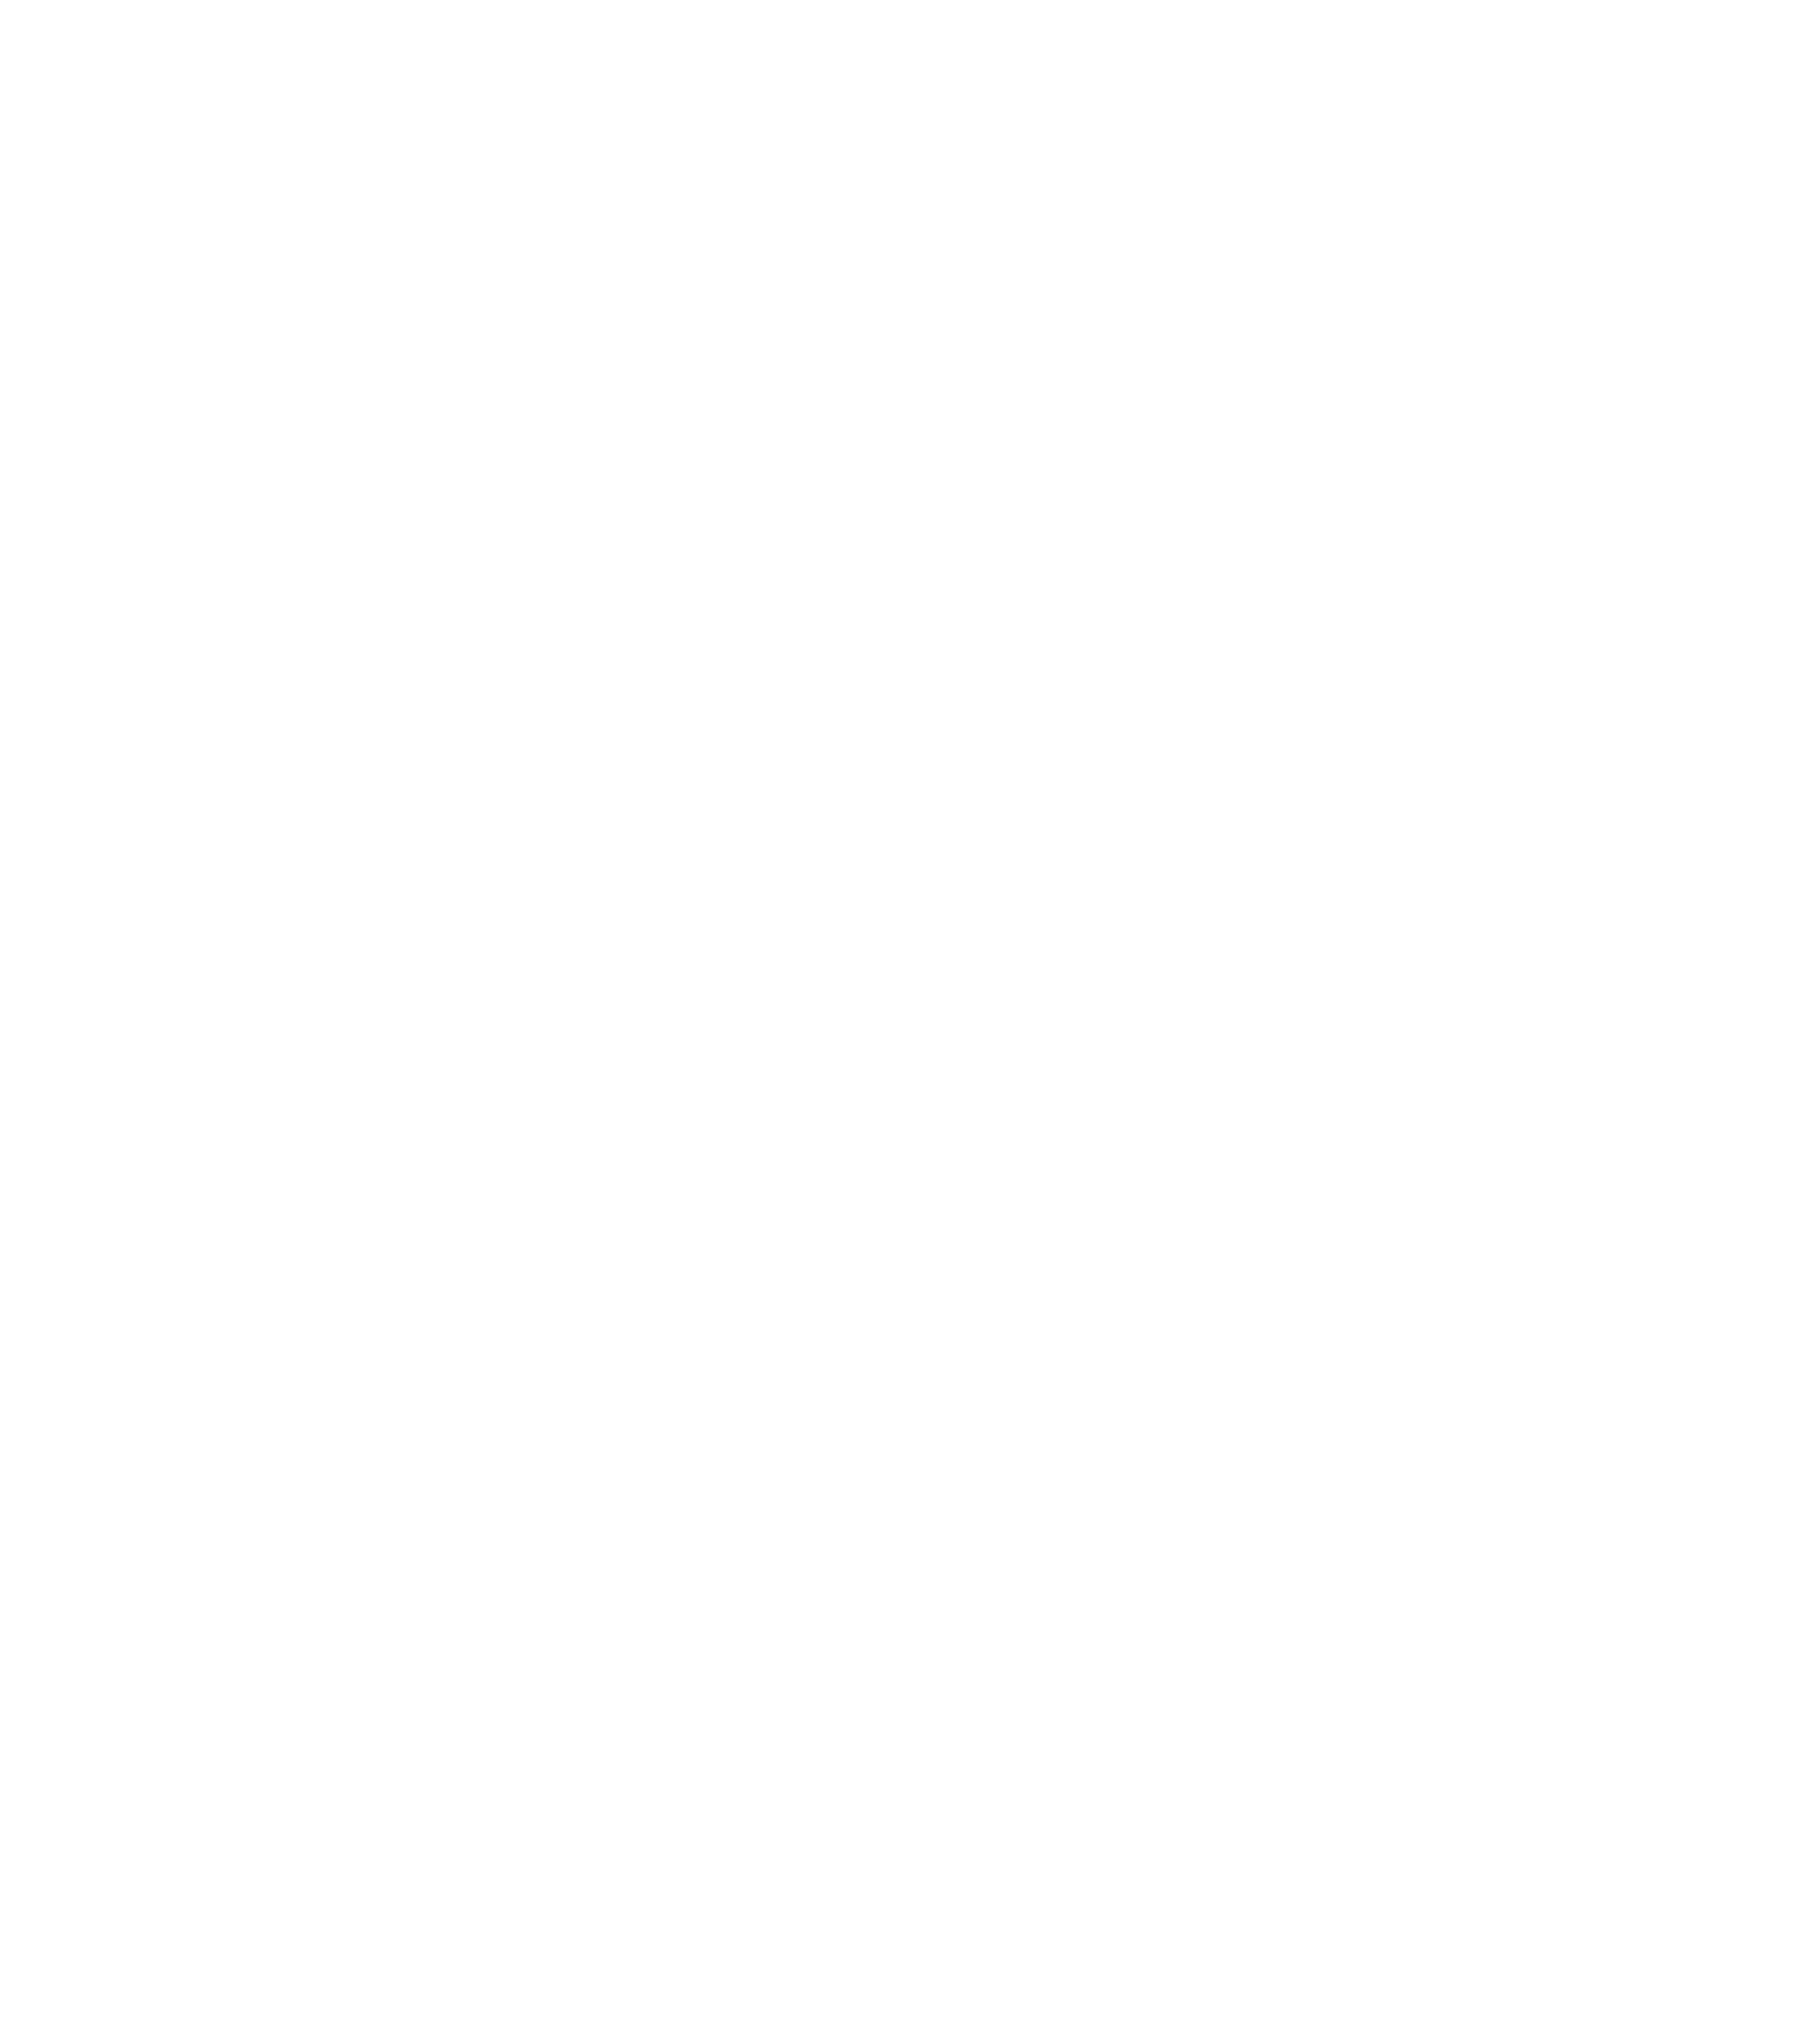

In [15]:
glycolysis_ppp_ov_simplified = build_pathway('glycolysis_ppp_ov_simplified', 'Glycolysis + PPP + Overflow (simplified)')
SVG(escher_map.EscherMap(glycolysis_ppp_ov_simplified.diagram, width="12cm").draw())

## Save the pathways

In [16]:
KB.put(KB.pathways, glycolysis)
KB.put(KB.pathways, glycolysis_ppp_ov)
KB.put(KB.pathways, glycolysis_ppp_ov_simplified)